# Imports

In [ ]:
!pip install -U torch

In [1]:
!pip install gstools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.7/167.7 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 3.7 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from gstools import SRF, Gaussian
from gstools.random import MasterRNG
from scipy import integrate

`gstools` is a library which can be used to generate random fields. This will be used in the DeepONet model to generate the training data.

See this [tutorial](https://geostat-framework.readthedocs.io/projects/gstools/en/v1.1.1/tutorial_01_srf.html) for more information on how to use `gstools` to generate random fields.

# DeepONet

For details about the DeepONet model, see the [md file](https://github.com/Hari31416/APL745/blob/main/Notes/DeepONet.md). The original article can be found [here](https://arxiv.org/abs/1910.03193).

Here, we'll use the model to solve the anti-derivative problem given in the article.

## Problem Statement

Let's consider the following problem:
$$
\frac{ds(x)}{dx} = u(x), \quad x\in [0,1]
$$

We need to solve the above problem for any $s(x)$, at any $x\in [0,1]$. We'll use the DeepONet model to solve this problem. Let the operator corresponding to the above problem be $G$.

We can see that it is nothing but the antiderivative operator, ie.:

$$
G:u(x) \mapsto s(x) = \int_0^x u(x) dx
$$

## Generating Data

Here is the data generation process:
1. Create $m$ points $x_i$ from $[0,1]$.
2. Generate $n$ random field $u_i$ using Gaussian random field.
3. The points at which the random field is evaluated are $x_i$. This way, we have a matrix of form $m\times n$ for $u(x_{ij})$ for $i^{th}$ random field and $j^{th}$ point.
4. Now compute $s(x_{ij})$ for $i^{th}$ random field and $j^{th}$ point.

So, we have the following data:
1. $m$ points $x_i$ from $[0,1]$.
2. $n$ random fields $u_i$.
3. $m\times n$ matrix of $U$.
4. $m\times n$ matrix of $S$.

We'll use $m=100, n = 110$.

In [3]:
m = 100
n = 110

Let's generate the data.

In [4]:
x = np.linspace(0, 1, m)

In [5]:
seed = MasterRNG(20170519)
def one_function(x):
    model = Gaussian(dim=1, var=3, len_scale=0.3)
    srf = SRF(model, seed=seed())
    f = srf.structured([x])
    return f

In [6]:
U = np.zeros((m, n))
for i in range(m):
    U[:, i] = one_function(x)

Let's see how the field looks:

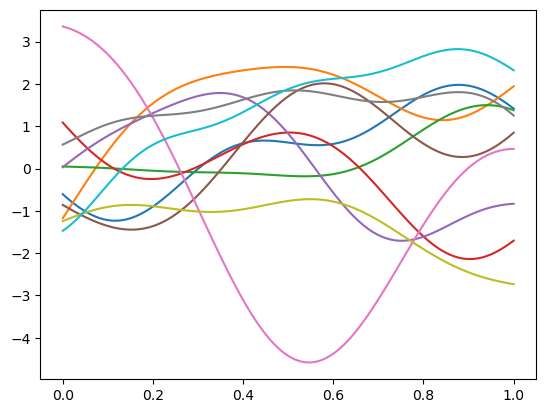

In [7]:
plt.plot(x, U[:, :10]);

Let's plot all the fields together:

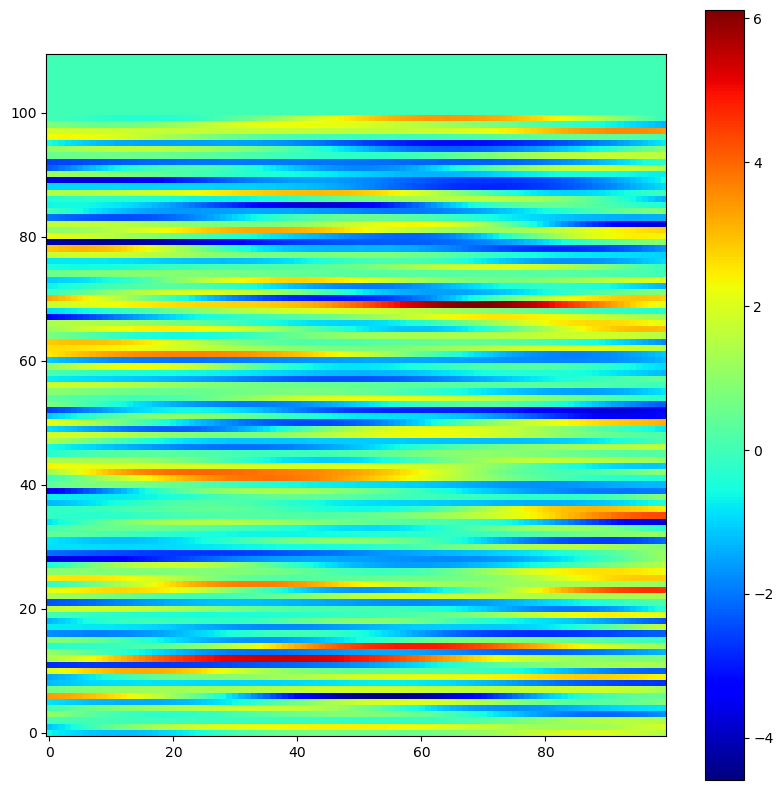

In [8]:
plt.figure(figsize=(10,10))
plt.imshow(U.T, cmap='jet', origin="lower")
plt.colorbar();

In [9]:
def integrate_one_function(f):
    result = np.zeros_like(f)
    result[0] = 0
    for i in range(1, len(f)):
        result[i] = integrate.simps(f[:i+1], x[:i+1])
    return result

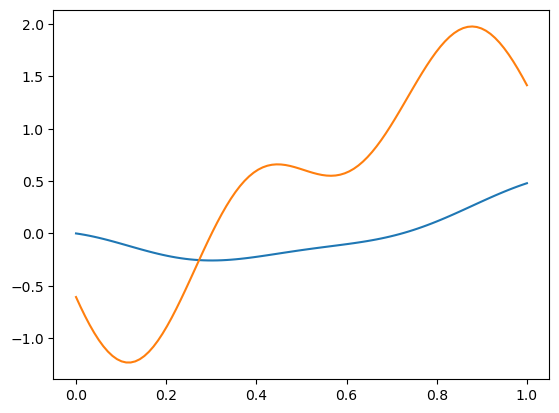

In [10]:
f = U[:, 0]
f_int = integrate_one_function(f)
plt.plot(x, f_int)
plt.plot(x, f);

Now let's integrate all functions. This will be our target function.

In [11]:
S = np.zeros((m, n))
for i in range(n):
    S[:, i] = integrate_one_function(U[:, i])

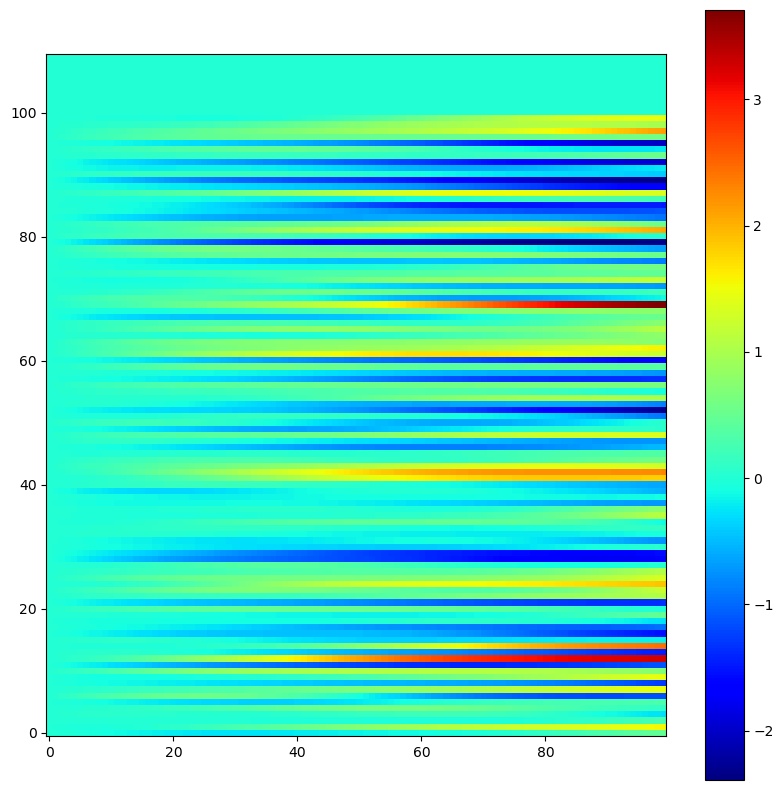

In [12]:
plt.figure(figsize=(10,10))
extent = [0, 1, 0, 1]
plt.imshow(S.T, cmap='jet', origin="lower")
plt.colorbar();

Now that we have data, we can go to the training process.

## Training Process

Here is the training process:

1. Chose one function $u_i$ from the n functions generated in the data generation process.
   1. Create a vector of $u_i(x_j)$ for all $x_j$ points, say $\mathbf{U_i}$.
   2. Chose a random point $x_k$ from $x_j$.
   3. Determine the value of $s_i(x_k)$ (you already have it), say $S_{ik}$.
   4. The input to the branch net will be $\mathbf{U_i}$ and that of the trunk net will be $S_{ik}$.
   5. The dot product of the output of the branch net and the output of the trunk net will be the predicted value of $S_{ik}$. Use MSE loss to train the model.
   6. Now, repeat the above steps for all $x_k$ points.
2. Now choose another function $u_j$ from the n functions generated in the data generation process.
   1. Repeat the above steps.
3. Repeat the above steps for all $u_i$ functions.

First, let's create the dataset in the format required by the model. We wil have two inputs:
1. The random field $u_i$ with shape $b\times m$.
2. The value of $x_i$ with shape $b\times 1$.

While the output will be the value of $s_i(x_i)$ with shape $b\times 1$. Here, $b$ is the batch size.

To create the dataset, we'll merge all the data generated above into a single list of tuples. Each tuple will have the format: `((u_i, x_i), s_i)` where `u_i = (u_1, u_2, ..., u_m)` and `x_i` and `s_i` are scalars. Stacking all the tuples will give us the dataset.

In [13]:
x.shape, U.shape, S.shape

((100,), (100, 110), (100, 110))

In [14]:
i = 10 #which function
j = 5 #which sensor
u = U[:, i]
x_ = x[j]
s = S[j, i]

u = torch.tensor(u, dtype=torch.float32).unsqueeze(1)
x_ = torch.tensor([x_], dtype=torch.float32).unsqueeze(1)
s = torch.tensor([s], dtype=torch.float32).unsqueeze(1)
u.shape, x_.shape, s.shape

(torch.Size([100, 1]), torch.Size([1, 1]), torch.Size([1, 1]))

In [15]:
U_train = torch.tensor(U, dtype=torch.float32)
x_train = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
S_train = torch.tensor(S, dtype=torch.float32)
U_train.shape, x_train.shape, S_train.shape

(torch.Size([100, 110]), torch.Size([100, 1]), torch.Size([100, 110]))

In [16]:
def interate_dataset(m=m, n=n , x=x, U=U, S=S):
    us = np.zeros((m*n, m))
    xs = np.zeros((m*n, 1))
    ss = np.zeros((m*n, 1))
    for i in range(n):
        for j in range(m):
            us[i*m+j, :] = U[:, i]
            xs[i*m+j, :] = x[j]
            ss[i*m+j, :] = S[j, i]
    return us, xs, ss

In [17]:
us, xs, ss = interate_dataset()
us.shape, xs.shape, ss.shape

((11000, 100), (11000, 1), (11000, 1))

In [18]:
def batch_dataset(batch_size, m=m, n=n , x=x, U=U, S=S, ratio=0.8):
    us, xs, ss = interate_dataset(m, n, x, U, S)
    train_size = int(len(us)*ratio)
    us_train = us[:train_size]
    xs_train = xs[:train_size]
    ss_train = ss[:train_size]
    
    us_test = us[train_size:]
    xs_test = xs[train_size:]
    ss_test = ss[train_size:]

    us_train = torch.tensor(us_train, dtype=torch.float32)
    xs_train = torch.tensor(xs_train, dtype=torch.float32)
    ss_train = torch.tensor(ss_train, dtype=torch.float32)
    train_dataset = torch.utils.data.TensorDataset(us_train, xs_train, ss_train)
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    us_test = torch.tensor(us_test, dtype=torch.float32)
    xs_test = torch.tensor(xs_test, dtype=torch.float32)
    ss_test = torch.tensor(ss_test, dtype=torch.float32)
    test_dataset = torch.utils.data.TensorDataset(us_test, xs_test, ss_test)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    return train_dataloader, test_dataloader

In [19]:
train_data, test_data = batch_dataset(32, ratio=0.99)#for now I'm not bothering with validating the model

In [20]:
for u_, x_, s_ in train_data:
    print(u_.shape, x_.shape, s_.shape)
    break

torch.Size([32, 100]) torch.Size([32, 1]) torch.Size([32, 1])


In [21]:
for u_, x_, s_ in test_data:
    print(u_.shape, x_.shape, s_.shape)
    break

torch.Size([32, 100]) torch.Size([32, 1]) torch.Size([32, 1])


>The way I created the dataset is not the most efficient way to do it. As our dataset will increase, we'll start having trouble. It works for now, though!

Now, we have the data ready. Let's create the model and train it.

## The Model

Here is the model:

In [22]:
# Implement a torch module for two inputs
class DeepONet(nn.Module):
    def __init__(self, neurons=40, in1=1, in2=1, output_neurons=20):
        super(DeepONet, self).__init__()
        self.neurons = neurons
        self.in1 = in1
        self.in2 = in2
        self.output_neurons = output_neurons
        self.b = torch.nn.parameter.Parameter(torch.tensor(0.0))
        self.b1 = self._branch_one()
        self.b2 = self._branch_two()

    def _branch_one(self):
        b1 = nn.Sequential(
            nn.Linear(self.in1, self.neurons),
            nn.ReLU(),
            nn.Linear(self.neurons, self.neurons),
            nn.ReLU(),
            nn.Linear(self.neurons, self.output_neurons),
        )
        return b1
    
    def _branch_two(self):
        b2 = nn.Sequential(
            nn.Linear(self.in2, self.neurons),
            nn.ReLU(),
            nn.Linear(self.neurons, self.neurons),
            nn.ReLU(),
            nn.Linear(self.neurons, self.neurons),
            nn.ReLU(),
            nn.Linear(self.neurons, self.output_neurons),
        )
        return b2
        
    def forward(self, x1, x2):
        x1 = self.b1(x1)
        x2 = self.b2(x2)
        x = torch.einsum("bi,bi->b", x1, x2)
        x = torch.unsqueeze(x, 1)
        x+=self.b
        return x

In [23]:
model = DeepONet(neurons=40, in1=m, in2=1)
model

DeepONet(
  (b1): Sequential(
    (0): Linear(in_features=100, out_features=40, bias=True)
    (1): ReLU()
    (2): Linear(in_features=40, out_features=40, bias=True)
    (3): ReLU()
    (4): Linear(in_features=40, out_features=20, bias=True)
  )
  (b2): Sequential(
    (0): Linear(in_features=1, out_features=40, bias=True)
    (1): ReLU()
    (2): Linear(in_features=40, out_features=40, bias=True)
    (3): ReLU()
    (4): Linear(in_features=40, out_features=40, bias=True)
    (5): ReLU()
    (6): Linear(in_features=40, out_features=20, bias=True)
  )
)

We'll use MSE for loss:

In [24]:
def loss(y_pred, y):
    return torch.mean((y_pred - y)**2)

Adam will be used as optimizer:

In [25]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [26]:
train_losses = []
epochs = 2000
for i in range(epochs):
    l_total = 0
    for u_, x_, s_ in train_data:
        model.train()
        optimizer.zero_grad()
        y_pred = model(u_, x_)
        l = loss(y_pred, s_)
        l_total += l.item()
        l.backward()
        optimizer.step()
        
    l_total = l_total/len(train_data)
    train_losses.append(l_total)
    if i % 20 == 0:
        print(f'Epoch: {i:>4d}/{epochs}, Loss: {l_total:6f}')
    


Epoch:    0/2000, Loss: 0.034314
Epoch:   20/2000, Loss: 0.000514
Epoch:   40/2000, Loss: 0.000188
Epoch:   60/2000, Loss: 0.000339
Epoch:   80/2000, Loss: 0.000190
Epoch:  100/2000, Loss: 0.000188
Epoch:  120/2000, Loss: 0.000277
Epoch:  140/2000, Loss: 0.000193
Epoch:  160/2000, Loss: 0.000081
Epoch:  180/2000, Loss: 0.000193
Epoch:  200/2000, Loss: 0.000161
Epoch:  220/2000, Loss: 0.000066
Epoch:  240/2000, Loss: 0.000179
Epoch:  260/2000, Loss: 0.000207
Epoch:  280/2000, Loss: 0.000055
Epoch:  300/2000, Loss: 0.000130
Epoch:  320/2000, Loss: 0.000135
Epoch:  340/2000, Loss: 0.000066
Epoch:  360/2000, Loss: 0.000066
Epoch:  380/2000, Loss: 0.000258
Epoch:  400/2000, Loss: 0.000077
Epoch:  420/2000, Loss: 0.000040
Epoch:  440/2000, Loss: 0.000063
Epoch:  460/2000, Loss: 0.000049
Epoch:  480/2000, Loss: 0.000173
Epoch:  500/2000, Loss: 0.000133
Epoch:  520/2000, Loss: 0.000070
Epoch:  540/2000, Loss: 0.000076
Epoch:  560/2000, Loss: 0.000073
Epoch:  580/2000, Loss: 0.000058
Epoch:  60

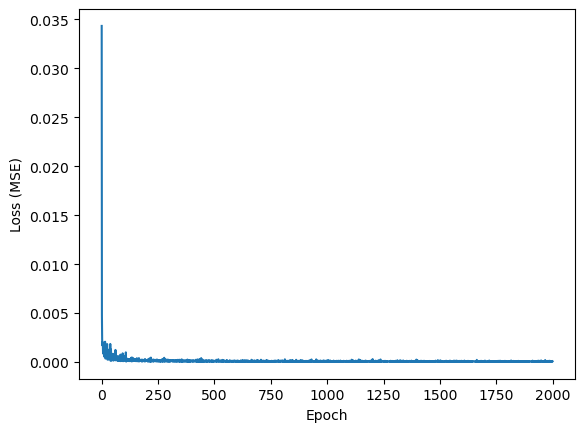

In [27]:
plt.plot(train_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.show()

## Verification

Here, we'll verify whether the model has indeed been able to learn the integration operator. We will try two functions

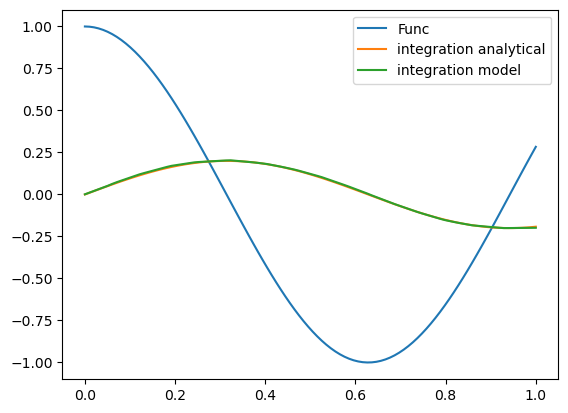

In [28]:
my_func = lambda x: np.cos(5*x)
inter = lambda x: 1/5*np.sin(5*x)
u_t = my_func(x)
s_t = inter(x)

model.eval()
u_t_ = torch.tensor(u_t, dtype=torch.float32).unsqueeze(0)
x_ = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
p = model(u_t_, x_)
p = p.detach().numpy()

plt.plot(x, u_t, label="Func")
plt.plot(x, s_t, label="integration analytical")
plt.plot(x, p, label="integration model")
plt.legend();

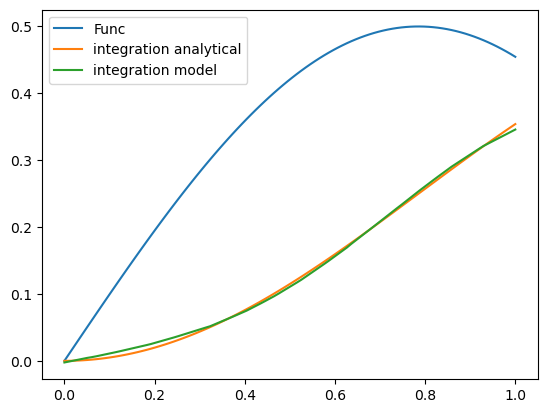

In [29]:
my_func = lambda x: np.cos(x)*np.sin(x)
inter = lambda x: 1/2*(np.sin(x))**2
u_t = my_func(x)
s_t = inter(x)

model.eval()
u_t_ = torch.tensor(u_t, dtype=torch.float32).unsqueeze(0)
x_ = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
p = model(u_t_, x_)
p = p.detach().numpy()

plt.plot(x, u_t, label="Func")
plt.plot(x, s_t, label="integration analytical")
plt.plot(x, p, label="integration model")
plt.legend();

It seems the network has _somewhat_ leared the integration operator. The learning can be donw better if we use more epochs and/or more senser points.